# Modeling

Next step in the project is to begin creating models that can predict whether an area is at risk of wildfire based on satelite photos. The Satelite photos was generated in Notebook 1 and further visualized in Notebook 2.

### Packages

In [1]:
# Packages:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import folium
import numpy as np
import pandas as pd
import os
import random
import cv2

from matplotlib import pyplot as plt
from matplotlib import image as mpimgz

# Dataload and preprocessing

First step is to preprocess the 2 dataset containing satellite photos and splitting them into 3 dataset for training, validation and test. Keras preprocessing is used to load images and format them to size 224*224 before converting them into arrays of (224, 224, 3) to have one array for each color in RGB. List containing a label of either 0 or 1 depending on the class is also created in this step.

### Fire data

In [2]:
# Set the path to the folder containing PNG images
folder_path_fire = 'fire'


In [3]:
# Define the fraction of the data to use for training, validation, and testing
train_fraction = 0.6 * len(os.listdir(folder_path_fire))
val_fraction = 0.2 * len(os.listdir(folder_path_fire))
test_fraction = 0.2

# Initialize lists to store the data
train_images_fire = []
train_labels_fire = []
val_images_fire = []
val_labels_fire = []
test_images_fire = []
test_labels_fire = []



# Loop through all the PNG files in the folder
for filename in os.listdir(folder_path_fire):
    if filename.endswith('.png'):
        img = f'{folder_path_fire}/{filename}'
        image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        
        # Add the image array and its corresponding label (which is always 1) to the appropriate list
        if len(train_images_fire) < train_fraction:
            train_images_fire.append(img_array)
            train_labels_fire.append(1)
        elif len(val_images_fire) < val_fraction:
            val_images_fire.append(img_array)
            val_labels_fire.append(1)
        else:
            test_images_fire.append(img_array)
            test_labels_fire.append(1)

# Convert the lists to numpy arrays
X_train_fire = np.array(train_images_fire)
y_train_fire = np.array(train_labels_fire)
X_val_fire = np.array(val_images_fire)
y_val_fire = np.array(val_labels_fire)
X_test_fire = np.array(test_images_fire)
y_test_fire = np.array(test_labels_fire)

### No fire data:

In [4]:
# Set the path to the folder containing PNG images
folder_path_nofire = 'no_fire' # Local

In [5]:
# Initialize lists to store the data
train_images_nofire = []
train_labels_nofire = []
val_images_nofire = []
val_labels_nofire = []
test_images_nofire = []
test_labels_nofire = []

# Loop through all the PNG files in the folder
for filename in os.listdir(folder_path_nofire):
    if filename.endswith('.png'):
        img = f'{folder_path_nofire}/{filename}'
        image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        
        # Add the image array and its corresponding label (which is always 0) to the appropriate list
        if len(train_images_nofire) < train_fraction:
            train_images_nofire.append(img_array)
            train_labels_nofire.append(0)
        elif len(val_images_nofire) < val_fraction:
            val_images_nofire.append(img_array)
            val_labels_nofire.append(0)
        else:
            test_images_nofire.append(img_array)
            test_labels_nofire.append(0)

# Convert the lists to numpy arrays
X_train_nofire = np.array(train_images_nofire)
y_train_nofire = np.array(train_labels_nofire)
X_val_nofire = np.array(val_images_nofire)
y_val_nofire = np.array(val_labels_nofire)
X_test_nofire = np.array(test_images_nofire)
y_test_nofire = np.array(test_labels_nofire)

## Combine the two datasets into one:

Next the generated arrays containing fire or no fire is concatenated to create one array for images and labels for each of the 3 splits.

In [6]:
X_train = np.concatenate((X_train_fire, X_train_nofire))
y_train = np.concatenate((y_train_fire, y_train_nofire))

X_val = np.concatenate((X_val_fire, X_val_nofire))
y_val = np.concatenate((y_val_fire, y_val_nofire))

X_test = np.concatenate((X_test_fire, X_test_nofire))
y_test = np.concatenate((y_test_fire, y_test_nofire))

In [7]:
print('X_train: ', len(X_train))
print('y_train: ', len(y_train))
print('X_val: ', len(X_val))
print('y_val: ', len(y_val))
print('X_test: ', len(X_test))
print('y_test: ', len(y_test))

X_train:  2212
y_train:  2212
X_val:  738
y_val:  738
X_test:  738
y_test:  738


The number of elements in each split is as expected.

# Baseline CNN model

First a baseline CNN model can be created using convolution layers and maxpooling layers. The model uses a dense layer with 1 neuron with sigmoid activation layer as the last layer to get a 0 to 1 value of high likely a wildfire in next period of 2 to 7 months is.

In [16]:
baseline_model = tf.keras.Sequential([
    # Convolutional layer 1 with 32 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # Max pooling layer 1 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Convolutional layer 3 with 128 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer 3 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Flatten layer to transform 3D tensor to a 1D tensor
    tf.keras.layers.Flatten(),
    # Dense layer 1 with 215 neurons, activation function ReLU
    tf.keras.layers.Dense(215, activation='relu'),
    # Dense layer 2 with 1 neurons (output layer), activation function Sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with categorical crossentropy loss and Adam optimizer
baseline_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer="Adam", metrics=['accuracy'])

# Print model summary
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 215)              

In [17]:
tf.random.set_seed(42)

baseline_history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
70/70 [==============================] - 31s 371ms/step - loss: 89.8304 - accuracy: 0.5258 - val_loss: 0.7559 - val_accuracy: 0.5176
Epoch 2/10
70/70 [==============================] - 24s 348ms/step - loss: 0.6665 - accuracy: 0.6261 - val_loss: 0.7521 - val_accuracy: 0.5596
Epoch 3/10
70/70 [==============================] - 22s 319ms/step - loss: 0.5311 - accuracy: 0.7437 - val_loss: 0.8267 - val_accuracy: 0.5556
Epoch 4/10
70/70 [==============================] - 23s 332ms/step - loss: 0.4047 - accuracy: 0.8250 - val_loss: 0.9966 - val_accuracy: 0.5759
Epoch 5/10
70/70 [==============================] - 22s 315ms/step - loss: 0.2791 - accuracy: 0.8956 - val_loss: 1.3948 - val_accuracy: 0.5840
Epoch 6/10
70/70 [==============================] - 22s 317ms/step - loss: 0.2168 - accuracy: 0.9304 - val_loss: 1.5915 - val_accuracy: 0.5528
Epoch 7/10
70/70 [==============================] - 23s 324ms/step - loss: 0.1579 - accuracy: 0.9543 - val_loss: 1.6315 - val_accuracy: 0.575

The performance of this baseline model can then be evaluated.

In [19]:
loss, accuracy = baseline_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

Test accuracy: 0.6029810309410095


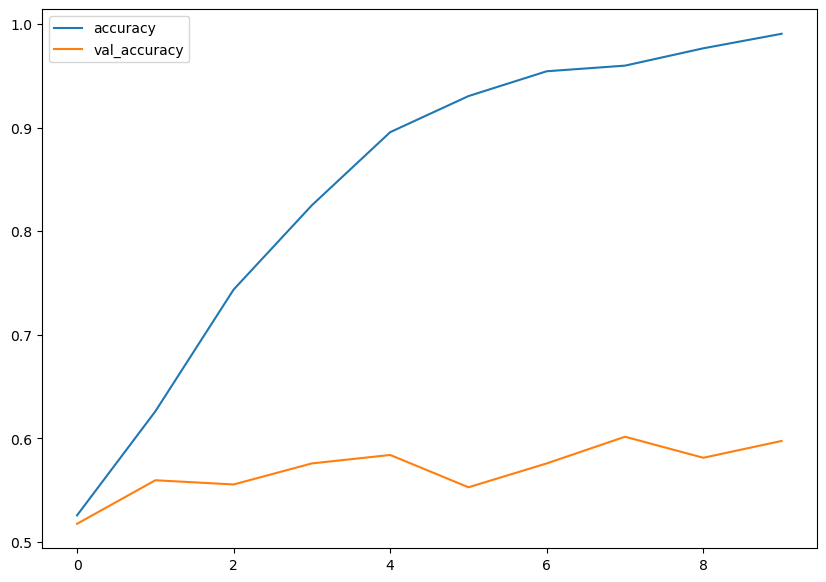

In [20]:
history = pd.DataFrame(baseline_history.history)
pd.DataFrame(history[['accuracy', 'val_accuracy']]).plot(figsize=(10,7));

There is room for improvement for this model. Using more layers and dropout, it would be expected to get better accuracy on the validation and test set. It seems that the model overfits on the training set because of the high number of parameters.

## Expanded model

The expanded has more layers and dropout to prevent overfitting on the training set.

In [24]:
expanded_model = tf.keras.Sequential([
    # Convolutional layer 1 with 32 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # Max pooling layer 1 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Convolutional layer 2 with 64 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # Max pooling layer 2 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Convolutional layer 3 with 128 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer 3 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Flatten layer to transform 3D tensor to a 1D tensor
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.5),
    # Dense layer 1 with 512 neurons, activation function ReLU
    tf.keras.layers.Dense(512, activation='relu'),
    # Dense layer 2 with 1 neurons (output layer), activation function Sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with categorical crossentropy loss and Adam optimizer
expanded_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer="Adam", metrics=['accuracy'])

# Print model summary
expanded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 51, 51, 64)       

In [25]:
tf.random.set_seed(42)

history = expanded_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
70/70 [==============================] - 18s 221ms/step - loss: 25.0904 - accuracy: 0.5312 - val_loss: 0.6838 - val_accuracy: 0.5095
Epoch 2/15
70/70 [==============================] - 13s 183ms/step - loss: 0.6975 - accuracy: 0.5366 - val_loss: 0.7344 - val_accuracy: 0.4946
Epoch 3/15
70/70 [==============================] - 12s 177ms/step - loss: 0.6531 - accuracy: 0.6035 - val_loss: 0.6486 - val_accuracy: 0.6084
Epoch 4/15
70/70 [==============================] - 13s 189ms/step - loss: 0.5942 - accuracy: 0.6596 - val_loss: 0.6379 - val_accuracy: 0.6423
Epoch 5/15
70/70 [==============================] - 13s 184ms/step - loss: 0.5487 - accuracy: 0.6962 - val_loss: 0.5937 - val_accuracy: 0.7263
Epoch 6/15
70/70 [==============================] - 13s 186ms/step - loss: 0.5177 - accuracy: 0.7414 - val_loss: 0.5296 - val_accuracy: 0.7575
Epoch 7/15
70/70 [==============================] - 13s 184ms/step - loss: 0.4889 - accuracy: 0.7550 - val_loss: 0.6477 - val_accuracy: 0.664

This model can then be tested on the test set to find the accuracy and the distribution of the predictions. The history can also be shown to analyze the training.

In [27]:
loss, accuracy = expanded_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

Test accuracy: 0.7425474524497986


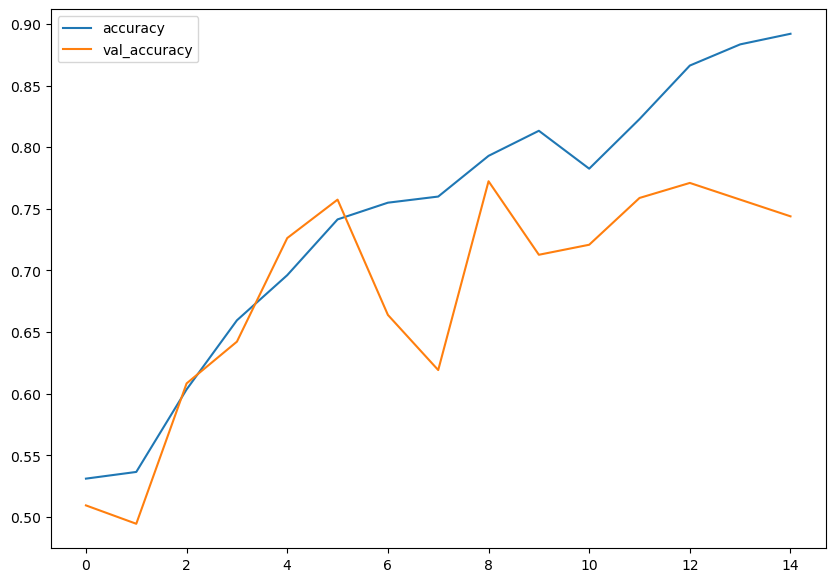

In [28]:
history = pd.DataFrame(history.history)
pd.DataFrame(history[['accuracy', 'val_accuracy']]).plot(figsize=(10,7));

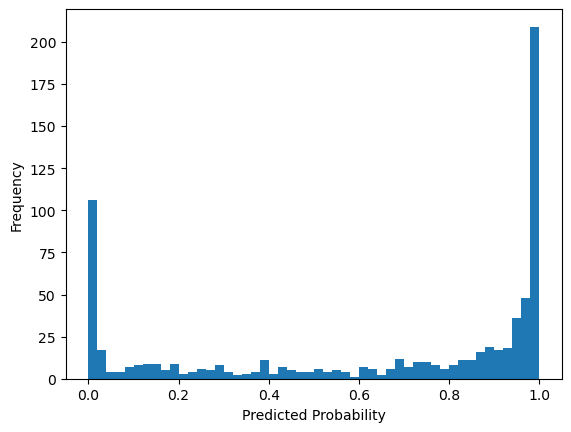

In [32]:
y_pred = expanded_model.predict(X_test, verbose=0)
plt.hist(y_pred, bins=50)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

This model performs a lot better than the baseline model, but still overfits on the training set. Pre-trained models should therefore be included to get a better performance.

# Pre-trained models

## CNN with pre-trained ResNet50

First model to be used is the pre-trained ResNet50. New layers are added to the end of the model to adjust for this case.

In [33]:
# Create an instance of the ResNet50 model and specify the input shape to match the images
resnet_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# ResNet50 model

# Freeze the layers of the ResNet50 model to prevent their weights from being updated during training
for layer in resnet_model.layers:
    layer.trainable = False


# Add own layers on top of the ResNet50 model
resnet_model = tf.keras.Sequential([
    resnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and an optimizer of your choice
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
#Train and evaluate the model using on data:
history = resnet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = resnet_model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
70/70 [==============================] - 52s 687ms/step - loss: 5.0097 - accuracy: 0.7712 - val_loss: 0.8986 - val_accuracy: 0.8252
Epoch 2/5
70/70 [==============================] - 44s 624ms/step - loss: 0.4271 - accuracy: 0.8757 - val_loss: 0.4294 - val_accuracy: 0.8509
Epoch 3/5
70/70 [==============================] - 42s 606ms/step - loss: 0.1653 - accuracy: 0.9372 - val_loss: 0.5543 - val_accuracy: 0.8537
Epoch 4/5
70/70 [==============================] - 44s 624ms/step - loss: 0.1625 - accuracy: 0.9453 - val_loss: 0.4639 - val_accuracy: 0.8591
Epoch 5/5
24/24 [==============================] - 10s 390ms/step - loss: 0.3783 - accuracy: 0.8591
Test accuracy: 0.859078586101532


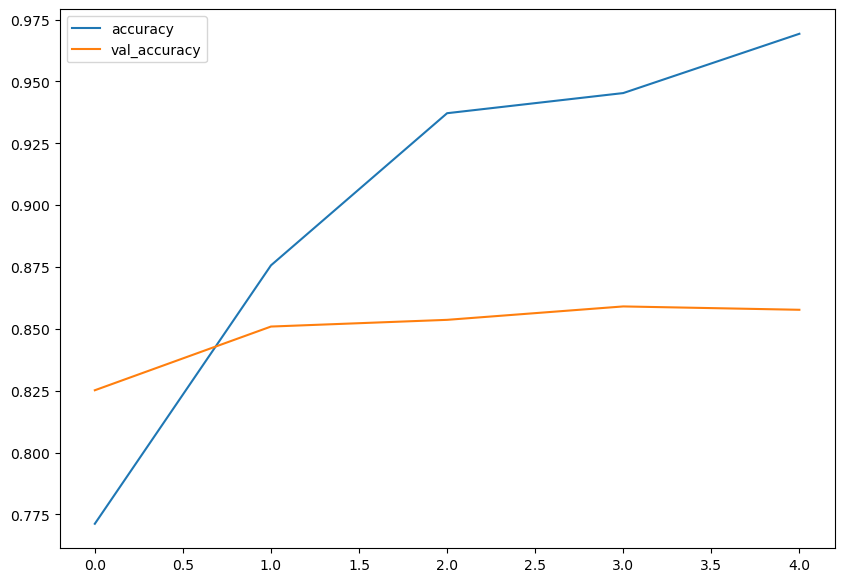

In [35]:
history = pd.DataFrame(history.history)
pd.DataFrame(history[['accuracy', 'val_accuracy']]).plot(figsize=(10,7));

This model performs a lot better than the baseline and expanded models as expected.

## CNN with pretrained model: InceptionV3

Next model to test is InceptionV3 with the same layers afterwards as the ResNet model.

In [39]:
# Create an instance of the InceptionV3 model and specify the input shape to match the images
inception_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers of the InceptionV3 model to prevent their weights from being updated during training
for layer in inception_model.layers:
    layer.trainable = False

# Add own layers on top of the InceptionV3 model
inception_model = tf.keras.Sequential([
    inception_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and an optimizer of your choice
inception_model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])


In [40]:
#Train and evaluate the model using on data:
history = inception_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = inception_model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
70/70 [==============================] - 32s 391ms/step - loss: 74.5281 - accuracy: 0.5967 - val_loss: 21.8589 - val_accuracy: 0.5949
Epoch 2/10
70/70 [==============================] - 22s 318ms/step - loss: 5.2747 - accuracy: 0.5963 - val_loss: 0.6030 - val_accuracy: 0.6748
Epoch 3/10
70/70 [==============================] - 22s 318ms/step - loss: 0.6430 - accuracy: 0.5818 - val_loss: 0.5758 - val_accuracy: 0.7073
Epoch 4/10
70/70 [==============================] - 22s 317ms/step - loss: 0.5859 - accuracy: 0.6212 - val_loss: 0.6025 - val_accuracy: 0.6314
Epoch 5/10
70/70 [==============================] - 22s 320ms/step - loss: 0.7384 - accuracy: 0.6329 - val_loss: 0.6040 - val_accuracy: 0.6314
Epoch 6/10
70/70 [==============================] - 22s 319ms/step - loss: 0.5817 - accuracy: 0.6297 - val_loss: 0.5952 - val_accuracy: 0.6531
Epoch 7/10
70/70 [==============================] - 22s 310ms/step - loss: 0.5696 - accuracy: 0.6239 - val_loss: 0.5747 - val_accuracy: 0.67

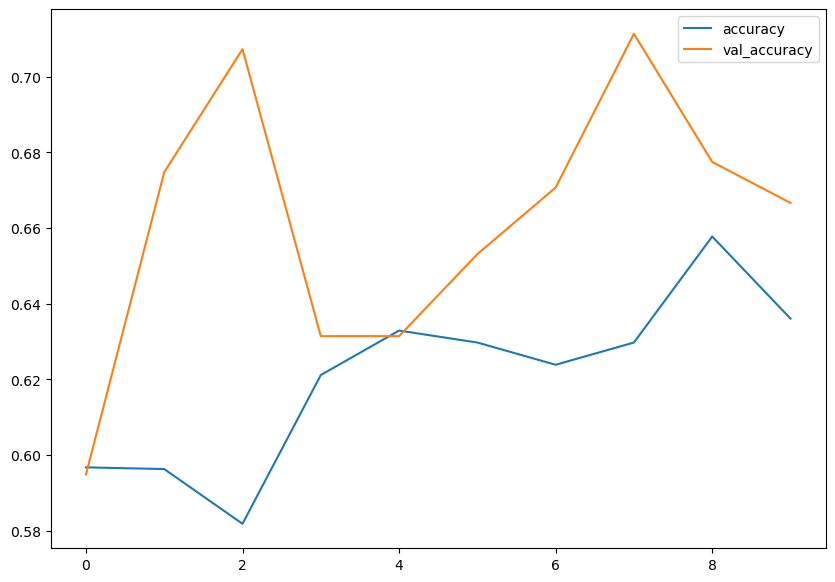

In [41]:
history = pd.DataFrame(history.history)
pd.DataFrame(history[['accuracy', 'val_accuracy']]).plot(figsize=(10,7));

## Mapping new test spots to create visualization

In [42]:
test = pd.read_csv('https://raw.githubusercontent.com/meriams/ABA-project-/main/modeltestdata.csv')
test[['Lat', 'Long']] = test['Coordinates'].str.split(',', expand=True)

In [43]:
# Saving names of no fire pictures
folder_path = "Test"

In [44]:
# Choosing path for test folder
folder_path = "test"
test_images = []
lat = []
long = []

# Loop through all the PNG files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.png'):
        img = f'{folder_path}/{filename}'
        image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        spot = filename[:-4]
        lat_spot = test.Lat[test['ID Number'] == int(spot)]
        long_spot = test.Long[test['ID Number'] == int(spot)]
        
        lat.append(lat_spot.iloc[0][1:])
        long.append(long_spot.iloc[0][:-1])
        test_images.append(img_array)

test_images = np.array(test_images)

In [45]:
pred = resnet_model.predict(test_images, verbose=0)

In [46]:
# Creating a map of Oregon
oregon_map = folium.Map(location=[44.0, -120.5], zoom_start=7)

for i in range(len(pred)):
    if pred[i] > 0.67:
        Color = 'red'
    if pred[i] > 0.33:
        Color = 'orange'
    else:
        Color = 'green'
    
    folium.CircleMarker(location=[lat[i], long[i]], radius=1, color=Color, fill=True, fill_color=Color).add_to(oregon_map)
    
oregon_map

## Grad-Cam

In [47]:
class GradCAM:
    def __init__(self, model, class_idx, layer_name=None):
        self.model = model
        self.class_idx = class_idx
        self.layer_name = layer_name
        if self.layer_name is None:
            self.layer_name = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layer_name).output, self.model.output]
        )
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.class_idx]
        grads = tape.gradient(loss, convOutputs)
        guidedGrads = tf.cast(convOutputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

In [48]:
# defining the image
img_path = 'fire/04-531075-05.png'

In [49]:
# load image and preprocess
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)

In [54]:
# Use the GradCAM class to compute the heatmap and overlay it on the original image:
cam = GradCAM(model= resnet_model, class_idx=0)
heatmap = cam.compute_heatmap(img)
#heatmap, output = cam.overlay_heatmap(heatmap, img)

NameError: name 'Model' is not defined

In [55]:
# Plot the heatmap as an image
plt.imshow(heatmap)

# Add a colorbar to the plot
plt.colorbar()

# Show the plot
plt.show()

NameError: name 'heatmap' is not defined

In [56]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img.astype("float32") / 255.0

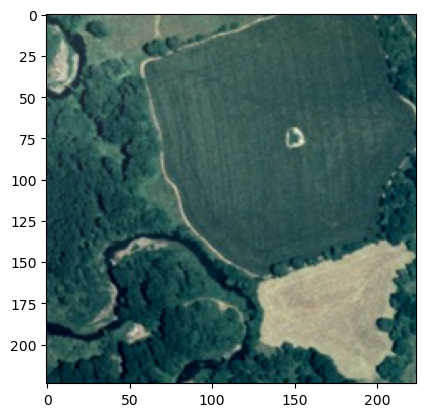

In [57]:
plt.imshow(img)
plt.show()

## Combining with other data

In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense

# Load the ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Freeze ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Define the input tensor for the model
input_tensor1 = Input(shape=(224, 224, 3))

x = resnet_model(input_tensor)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = keras.models.Model(inputs=input_tensor1, outputs=x)


input_tensor2 = input(shape=9) # Her kunne anden data tilføjes

y = Dense(36, activation='relu')(y)
y = Dense(36, activation='relu')(y)
x = keras.models.Model(inputs=input_tensor2, outputs=y)

combined = concatenate([x.output, y.output])

z = Dense(6, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = keras.models.Model(inputs=[x.input, y.input], outputs=z)

# Compile the combined model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [95]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
70/70 [==============================] - 64s 734ms/step - loss: 5.9152 - accuracy: 0.7726 - val_loss: 0.8344 - val_accuracy: 0.8388
Epoch 2/5
18/70 [======>.......................] - ETA: 26s - loss: 0.5125 - accuracy: 0.8889

KeyboardInterrupt: 